In [1]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

from event_clustering.preprocessing import *
from event_clustering.clustering import *
from event_clustering.postprocessing import *
from event_clustering.process_mining import *

from sklearn.cluster import *
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.metrics as metrics
import sklearn.metrics.cluster as cluster_metrics

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
#http://pm4py.pads.rwth-aachen.de/documentation/conformance-checking/evaluation-log-model/
from pm4py.evaluation import factory as evaluation_factory

import scipy.cluster.hierarchy as sch

# Load Encoded Events

In [3]:
# change the column name map to suit your dataset
column_name_map = {
    'timestamp': 'time:timestamp',
    'caseid' : 'case:id',
    'eventname' : 'concept:name',
    'resource' : 'org:resource',
    'role' : 'org:role',
}  

In [10]:
#feature names PREFIXES
feature_names = [
    'concept:name',
    'org:role',
    'feature_timedif_to',
    'feature_time_',
    'feature_position',
    'feature_window'
]

In [11]:
# experiments with indeces of feature names to be used
experiments = [
    [0],
    [0,1],
    [0,2],
    [0,1,2],
    [0,3],
    [0,1,3],
    [0,1,2,3]
]

In [5]:
data_folder = 'data/'
file_name = 'DomesticDeclarations'
df = preprocess(load(data_folder + file_name + '.xes'), column_name_map)
df_encoded = pd.read_csv(data_folder + file_name + '2_encoded.csv')
original_df_columns = df.columns

# Clustering

### KMeans

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters


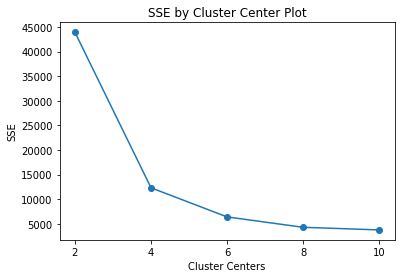

In [7]:
find_optimal_clusters(df_encoded, 10)

In [8]:
# set cluster number depending on experiment above
cluster_nr = 6

## Evaluation

Finished writing to CSV file.


/Users/azenner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use individual entry points instead
/Users/azenner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use individual entry points instead


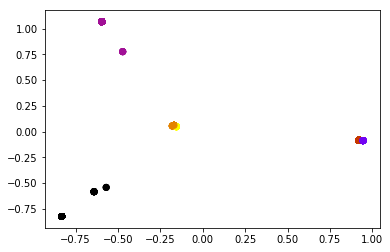

In [22]:
for experiment in experiments[1:2]:
    
    selected_feature_names = []
    column_names = []
    for name_index in experiment:
        feature_name = feature_names[name_index]
        selected_feature_names.append(feature_name.replace(":", ""))
        column_names.extend([x for x in df_encoded.columns if feature_name in x])
        
    experiment_name = file_name + '_exp_' + '+'.join(selected_feature_names)
    
    df_experiment = df_encoded[column_names]
    
    experiment_results_path_prefix = 'results/' + experiment_name
    
    km = MiniBatchKMeans(n_clusters=cluster_nr, init_size=1024, batch_size=2048, random_state=20)
    cluster_labels = km.fit_predict(df_experiment)
    
    np.save(experiment_results_path_prefix + '_cluster_labels', cluster_labels)
    
     #plot pca
    plot_pca(df_experiment, cluster_labels, experiment_results_path_prefix + '_pcaplot')
    
    # Silhouette
    silhouette_path = experiment_results_path_prefix + "_silhouette.txt"
    if os.path.exists(silhouette_path):
        os.remove(silhouette_path)
    silhouette = metrics.silhouette_score(df_experiment, cluster_labels)
    f = open(silhouette_path, "x")
    f.write(str(silhouette))
    f.close()
             
    # Completeness
    completeness_path = experiment_results_path_prefix + "_completeness.txt"
    if os.path.exists(completeness_path):
        os.remove(completeness_path)
    completness = metrics.completeness_score(df[column_name_map['eventname']], cluster_labels)
    f = open(completeness_path, "x")
    f.write(str(completness))
    f.close()
    
    abstracted_df = df.copy()
    abstracted_df[column_name_map['eventname']] = ['c_' + str(x) for x in cluster_labels]
    merge_subsequent_same_events(abstracted_df, column_name_map['caseid'], column_name_map['eventname'])
                                                 
    # write abstracted dataframe as csv file
    filepath_abstracted = data_folder + experiment_name + '_abstracted.csv'
    write_to_csv(abstracted_df, filepath_abstracted, index=False)
    
    # read logs with pm4py                                           
    original_log = read_as_log_xes(data_folder + file_name + '.xes')
    abstracted_log = read_as_log_csv(filepath_abstracted)
                                                 
    # Inductive Miner
    net_ind_orig, im_ind_orig, fm_ind_orig = inductive_miner.apply(original_log)
    net_ind, im_ind, fm_ind = inductive_miner.apply(abstracted_log)
                                                 
    visualize_as_petri_net(net_ind_orig, im_ind_orig, fm_ind_orig, experiment_results_path_prefix + '_petrinet.svg')
    visualize_as_petri_net(net_ind, im_ind, fm_ind, experiment_results_path_prefix + '_petrinet_abstracted.svg')
               
    model_metrics_original = evaluation_factory.apply(original_log, net_ind_orig, im_ind_orig, fm_ind_orig)
    model_metrics_abstracted = evaluation_factory.apply(abstracted_log, net_ind, im_ind, fm_ind)
    
    model_metrics_path = experiment_results_path_prefix + "_model_metrics.txt"
    if os.path.exists(model_metrics_path):
        os.remove(model_metrics_path)
    f = open(model_metrics_path, "x")
    f.write(str(model_metrics_original))
    f.close()
    
    model_metrics_abstracted_path = experiment_results_path_prefix + "_model_metrics_abstracted.txt"
    if os.path.exists(model_metrics_abstracted_path):
        os.remove(model_metrics_abstracted_path)
    f = open(model_metrics_abstracted_path, "x")
    f.write(str(model_metrics_abstracted))
    f.close()                                                                                          

In [182]:
# Check cluster labels "manually"
# group by cluster label and aggregate concept:name

# change experiment_results_path_prefix if you want to use the cluster labels of another experiment
cluster_labels = np.load(experiment_results_path_prefix + '_cluster_labels.npy')
df2 = df.copy()
df2['cluster_labels'] = cluster_labels
eval_manually = df.groupby('cluster_label')[column_name_map['eventname']].apply(set)
eval_manually

cluster_label
0    {Declaration SUBMITTED by EMPLOYEE, Request Payment, Declaration FINAL_APPROVED by SUPERVISOR, Declaration APPROVED by ADMINISTRATION}                                                                                                                                                                                                 
1    {Request Payment, Declaration REJECTED by SUPERVISOR, Declaration FINAL_APPROVED by SUPERVISOR, Declaration FOR_APPROVAL by SUPERVISOR, Declaration SUBMITTED by EMPLOYEE}                                                                                                                                                             
2    {Request Payment, Declaration APPROVED by PRE_APPROVER, Declaration FOR_APPROVAL by PRE_APPROVER, Declaration APPROVED by ADMINISTRATION, Declaration REJECTED by PRE_APPROVER, Declaration FOR_APPROVAL by ADMINISTRATION, Declaration REJECTED by MISSING, Declaration REJECTED by ADMINISTRATION, Declaration SUBMITTED 